### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os

### Load matlab file

In [2]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('../matlab.mat')

### Import Procsim

In [4]:
import procsimulator

from procsimulator.CommunityGenerator import CommunityGenerator
from procsimulator.ConsumptionGenerator import ConsumptionGenerator

from procsimulator.DataFromSmile import DataFromSmile
from procsimulator.DataFromTomorrow import DataFromTomorrow
from procsimulator.RenewableEnergyGenerator import RenewableEnergyGenerator
from procsimulator.CommunityGenerator import CommunityGenerator

### Get community data (consumption, PV production, wind production, total production and netload)

In [5]:
current_path = os.getcwd()
path_steps_seconds = os.path.join(current_path, "..")
path_steps_minutes = "../output/minute"

pv_df = pd.read_csv(path_steps_minutes + '/netload.csv', sep=';')
pv_df.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']
pv_df['Date'] = pd.to_datetime(pv_df['Date'])
print(pv_df)

                     Date       Demand  PV_Production  Wind_Production  \
0     2022-10-16 00:00:00  1364.623333            0.0      2755.725373   
1     2022-10-16 00:01:00  1364.048333            0.0      2777.570346   
2     2022-10-16 00:02:00  1342.136667            0.0      2798.620373   
3     2022-10-16 00:03:00  1323.410000            0.0      2818.885116   
4     2022-10-16 00:04:00  1310.541667            0.0      2838.374237   
...                   ...          ...            ...              ...   
10074 2022-10-22 23:54:00  1350.063333            0.0     12974.885389   
10075 2022-10-22 23:55:00  1350.000000            0.0     12984.431798   
10076 2022-10-22 23:56:00  1455.931667            0.0     12993.978202   
10077 2022-10-22 23:57:00  1474.323333            0.0     13003.524600   
10078 2022-10-22 23:58:00   978.400000            0.0     13013.070993   

         Production       Netload  
0       2755.725373  -1391.102040  
1       2777.570346  -1413.522012  
2  

### Downsample data to 1 hour

In [6]:
pv_df = pv_df.resample('1H', on='Date').mean()
pv_df = pv_df.reset_index()
print(pv_df)

                   Date       Demand  PV_Production  Wind_Production  \
0   2022-10-16 00:00:00  1147.887028            0.0      3025.292680   
1   2022-10-16 01:00:00  1050.334972            0.0      2687.639917   
2   2022-10-16 02:00:00  1638.870250            0.0      2417.165755   
3   2022-10-16 03:00:00  1852.895528            0.0      2471.580335   
4   2022-10-16 04:00:00  3667.408667            0.0      1694.983397   
..                  ...          ...            ...              ...   
163 2022-10-22 19:00:00  4700.062583            0.0     10449.661167   
164 2022-10-22 20:00:00  2757.668444            0.0     11022.525277   
165 2022-10-22 21:00:00  5525.317972            0.0     11595.369077   
166 2022-10-22 22:00:00  2184.109278            0.0     12168.192568   
167 2022-10-22 23:00:00  1203.814096            0.0     12736.222502   

       Production       Netload  
0     3025.292680  -1877.405652  
1     2687.639917  -1637.304945  
2     2417.165755   -778.295505  

In [7]:
data['data']['storage']['limit'][0].shape

(24, 4)

### Concatenate loads, generators and storages in order to have 1 week instead of just 1 day

In [8]:

arrLoads = np.array(data['data']['load']['limit'][0])
arrGen  = np.array(data['data']['generator']['limit'][0])
arrStor  = np.array(data['data']['storage']['limit'][0])

arrTotLoads = []
arrTotGens = []
arrTotStor = []

num_days = 7

for i in range(num_days-1):
    arrLoads = np.concatenate((arrLoads, np.array(data['data']['load']['limit'][0])), axis=0)
    arrGen = np.concatenate((arrGen, np.array(data['data']['generator']['limit'][0])), axis=0)
    arrStor = np.concatenate((arrStor, np.array(data['data']['storage']['limit'][0])), axis=0)

for i in range(6):
    arrTotLoads = np.append(arrTotLoads, arrLoads)
    
for i in range(7):
    arrTotGens = np.append(arrTotGens, arrGen)
    
for i in range(3):
    arrTotStor = np.append(arrTotStor, arrStor)
    
    
data['data']['load']['limit'] = arrTotLoads.reshape((6,168,10))
data['data']['generator']['limit'] = arrTotGens.reshape((7,168,8))
data['data']['storage']['limit'] = arrTotStor.reshape((3,168,4))


### Change periods to 1 week instead of 1 day

In [9]:
data['data']['parameterData']['resources']['period'] = 24*num_days

### Plot Wind Production

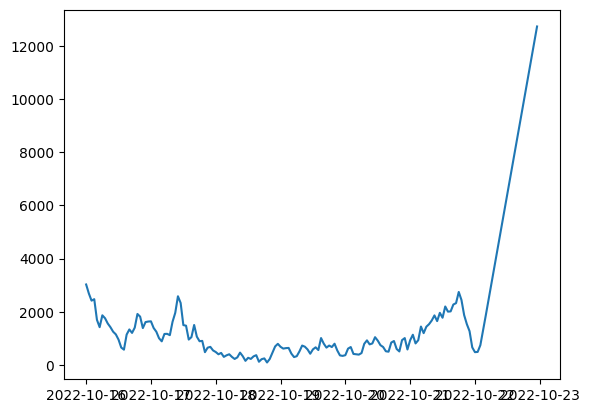

In [10]:
plt.plot(pv_df["Date"], pv_df["Wind_Production"])
plt.show()

### Plot PV Production

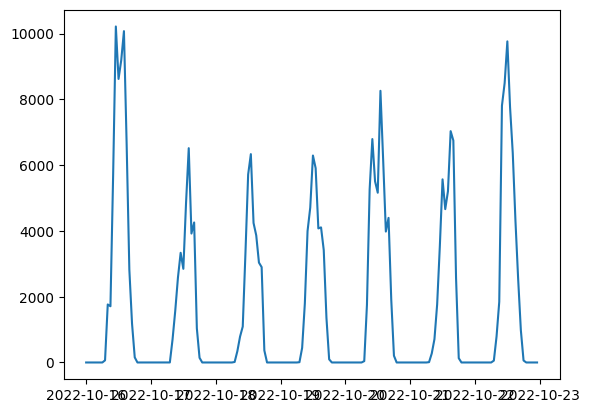

In [11]:
plt.plot(pv_df["Date"], pv_df["PV_Production"])
plt.show()

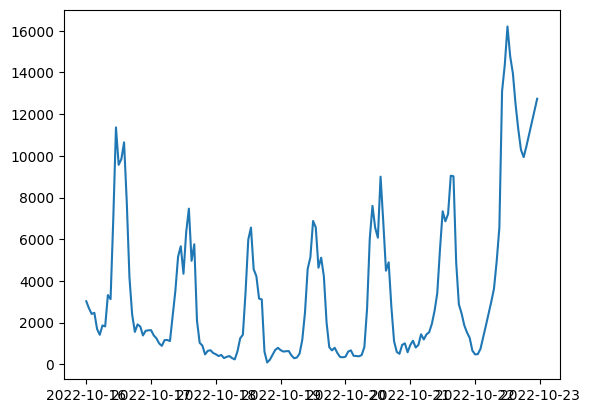

In [12]:
plt.plot(pv_df["Date"], pv_df["Production"])
plt.show()

### Change Consumption data in order to be used in the optimization model

In [13]:
cg = ConsumptionGenerator("../data.json", path_steps_seconds, path_steps_minutes)
community_size = len(cg.get_community())
num_generators = 2
num_storages = 1

data['data']['parameterData']['resources']['numGen'] = num_generators
data['data']['parameterData']['resources']['numLoad'] = community_size
data['data']['parameterData']['resources']['numStor'] = num_storages

data['data']['load']['limit'] = data['data']['load']['limit'][:community_size]
data['data']['load']['info'] = data['data']['load']['info'][:community_size]

data['data']['generator']['limit'] = data['data']['generator']['limit'][:num_generators]
data['data']['generator']['info'] = data['data']['generator']['info'][:num_generators]

data['data']['storage']['limit'] = data['data']['storage']['limit'][:num_storages]
data['data']['storage']['info'] = data['data']['storage']['info'][:num_storages]

for x in os.walk(path_steps_minutes):
    if x[0] is not path_steps_minutes:
        print(x[0])
        house_total_df = pd.read_csv(x[0] + '/total.csv', sep=';')
        house_total_df.columns = ['Date', 'Demand']
        house_total_df['Date'] = pd.to_datetime(house_total_df['Date'])
        house_total_df.set_index('Date')
        
        house_total_df = house_total_df.resample('1H', on='Date').mean()
                
        pos = int(x[0].split("house")[1])
        for y in range(len(data['data']['load']['limit'][pos])):
            data['data']['load']['limit'][pos][y][0] = house_total_df.iloc[y]["Demand"]/1000
            data['data']['load']['limit'][pos][y][1] = 0
            data['data']['load']['limit'][pos][y][2] = house_total_df.iloc[y]["Demand"]/1000*0.01
            data['data']['load']['limit'][pos][y][3] = house_total_df.iloc[y]["Demand"]/1000*0.01
            print(house_total_df.iloc[y]["Demand"])

../output/minute\house0
134.91030555555554
166.82061111111113
134.91030555555554
134.91030555555554
1437.4723888888889
273.7342777777778
491.68436111111106
269.30805555555554
256.9876388888889
360.68119444444443
187.7094722222222
151.14591666666666
189.73433333333332
208.4272222222222
188.1642222222222
187.6708888888889
184.2543611111111
360.26624999999996
134.91030555555554
301.452
769.2373333333333
129.21602777777778
141.21127777777778
188.59469444444446
134.91030555555554
134.91030555555554
134.91030555555554
134.91030555555557
134.91030555555554
134.91030555555557
124.47438888888888
145.34622222222222
362.6970277777778
160.5810555555555
360.2662222222222
1483.0824166666666
286.76858333333337
565.9020277777778
253.31708333333333
360.26624999999996
167.95583333333335
189.98799999999997
173.52599999999998
886.7092777777777
157.21525
150.8039722222222
159.4611111111111
162.15477777777778
1471.8556944444442
558.7251388888889
212.91275
190.86027777777778
134.91030555555554
134.9103055555

352.13652777777776
996.7550277777777
397.9388333333334
631.4975833333333
436.62325
401.8172777777778
393.88125
464.2922222222222
477.1988888888889
543.1743611111111
497.8983611111111
516.9034444444445
2542.4997777777776
590.2623333333333
341.1118333333333
372.2236666666667
341.1118333333333
684.9769166666666
1109.5701111111111
1176.053
966.8823611111111
1136.2943333333335
918.0951666666666
331.4689722222222
346.8148888888889
1028.5440555555556
413.9948611111111
596.6172499999999
479.81955555555555
1320.8562499999996
1335.4511666666665
714.3031666666667
519.8810277777778
504.65780555555557
491.8810277777778
440.3276388888889
2363.920055555556
675.2158611111112
461.17033333333336
734.498611111111
1720.2716666666668
1059.6796111111112
1137.2938333333334
1149.3109444444444
950.1102222222222
1157.7806944444444
572.7605555555555
328.90377777777775
365.54769444444446
1050.987361111111
461.8842777777778
1766.095527777778
635.5208055555555
1015.7435833333333
479.0406111111111
455.3141944444444


### Change generator type to 2 (Renewables) in the second generator

In [14]:
data['data']['generator']['info'][1][1] = 2

### Change battery info

In [15]:
# Change Energy Capacity to 10 kVAh
data['data']['storage']['info'][0][5] = 10

# Change P Charge Max to 3 kW
data['data']['storage']['info'][0][10] = 3

# Change P Discharge Max to 3 kW 
data['data']['storage']['info'][0][11] = 3

# Change Initial State to 0%
data['data']['storage']['info'][0][9] = 0

### Change pImp and pExp to near 0

In [16]:
data['data']['parameterData']['generalInfo']['P_Max_Imp'][:] = 1
data['data']['parameterData']['generalInfo']['P_Max_Exp'][:] = 1

### Change Production (Wind and PV) data in order to be used in the optimization model

In [17]:
#Add Production (Generator with type = 2 - Renewables)
for x in range(len(data['data']['generator']['limit'])):
    for y in range(len(data['data']['generator']['limit'][x])):
        if (x == 0): #PV
            data['data']['generator']['limit'][x][y][0] = pv_df.iloc[y]["PV_Production"]/1000
        else: #Wind
            data['data']['generator']['limit'][x][y][0] = pv_df.iloc[y]["Wind_Production"]/1000


### Linearize the generator prices

In [18]:
genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

### Options for simulation

In [19]:
iterlim = 1000000000
reslim = 5000000000

### Define the number of the used resources (generators, houses, periods, etc)

In [20]:
numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
#numPeriod = np.array([i%24+1 for i in range(0,168)])
numBus = np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [21]:
numPeriod

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168])

### Define the strings with the resources in order to be used by GAMS

In [22]:
gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
period = np.max(numPeriod)
Bus = np.max(numBus)

### Define the matrixes with the data in order to be used by GAMS

In [23]:
# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Generators
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
#genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]*num_days, :]
genInfo = data['data']['generator']['info']

# Loads
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
#loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]*num_days, :]

# Storages
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
#storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]*num_days, :]
storInfo = data['data']['storage']['info']

### Define the network data for the GAMS

In [24]:
# Branchs
branchData = data['data']['network']['branch']

# Maximum Voltage
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Minimum Voltage
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Maximum Angle
angleMax = data['data']['parameterData']['network']['angleMax']

# Minimum Angle
angleMin = data['data']['parameterData']['network']['angleMin']

# Defines the matrix of admitances
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

### Change MaxImp and MaxExp to support 1 week instead of just 1 day

In [25]:
arrImp = []
arrExp = []

for i in range(num_days):
    arrImp = np.append(arrImp, pMaxImp)
    arrExp = np.append(arrExp, pMaxExp)
    
pMaxImp = arrImp
pMaxExp = arrExp

### Change BuyPrice and SellPrice to support 1 week instead of just 1 day

In [26]:
arrBuy = []
arrSell = []

for i in range(num_days):
    arrBuy = np.append(arrBuy, buyPrice)
    arrSell = np.append(arrSell, sellPrice)
    
buyPrice = arrBuy
sellPrice = arrSell

### Reset the DG fixed and quadratic cost

In [27]:
genLimit.shape

(2, 168, 8)

In [28]:
genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(num_generators, 24*num_days, 4)), axis=2)

### Define the fixed sets structure to use in the parameters of the gams optimization process

In [29]:
NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)
storLimitInfo = np.arange(1, NCOLS+1)

### Define the several sets structure used in the gams optimization process

In [30]:
# these sets depends the number of resources used in matlab code

_t = np.arange(1, period+1)
_gen = np.arange(1, gen+1)
_Load = np.arange(1, Load+1)
_stor = np.arange(1, stor+1)

### Aux function to convert numpy into dictionaries

In [31]:
def _auxDictionary(a):
    temp_dictionary = {}
    
    if len(a.shape) == 3:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                for dim2 in np.arange(a.shape[2]):
                    temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
    elif len(a.shape) == 2:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]
                
    else:
        for dim0 in np.arange(a.shape[0]):
            temp_dictionary[(dim0+1)] = a[dim0]
                
    return temp_dictionary

#temp_dict1 = _auxDictionary(loadLimit)

### Pyomo Imports

In [32]:
import pyomo
import pyomo.opt
import pyomo.environ as pe

### Create the model

In [33]:
model = pe.ConcreteModel()

model.genLimitInfo = pe.Set(initialize=genLimitInfo, 
                            doc='Indicate the number of columns of information from generators')
model.loadLimitInfo = pe.Set(initialize=loadLimitInfo, 
                             doc='Indicate the number of columns of information from loads')
model.storLimitInfo = pe.Set(initialize=storLimitInfo, 
                             doc='Indicate the number of columns of information from storage units')

# Sets
model.t = pe.Set(initialize=_t, doc='period')
model.gen = pe.Set(initialize=_gen, doc='generators')
model.loads = pe.Set(initialize=_Load, doc='loads')
model.stor = pe.Set(initialize=_stor, doc='storage')

### Define the parameters with the data from the excel, such as limits, price, and voltage

In [34]:
model.loadLimit = pe.Param(model.loads, model.t, model.loadLimitInfo, 
                           initialize=_auxDictionary(loadLimit))

model.genLimit = pe.Param(model.gen, model.t, model.genLimitInfo,
                          initialize=_auxDictionary(genLimit))

model.genInfo = pe.Param(model.gen, model.genLimitInfo,
                         initialize=_auxDictionary(genInfo))

model.pMaxImp = pe.Param(model.t,
                         initialize=_auxDictionary(pMaxImp))

model.buyPrice = pe.Param(model.t,
                          initialize=_auxDictionary(buyPrice))

model.pMaxExp = pe.Param(model.t,
                         initialize=_auxDictionary(pMaxExp))

model.sellPrice = pe.Param(model.t,
                           initialize=_auxDictionary(sellPrice))

model.storLimit = pe.Param(model.stor, model.t, model.storLimitInfo,
                           initialize=_auxDictionary(storLimit))

model.storInfo = pe.Param(model.stor, model.storLimitInfo,
                          initialize=_auxDictionary(storInfo[:, :12]))

model.loadActPower = pe.Param(model.loads, model.t,
                              initialize=_auxDictionary(loadLimit[:, :, 0]))
model.optCost = pe.Var()#initialize=0)

### Define the variables for the gams optimization process

In [35]:
model.derCost = pe.Var(domain=pe.Reals, initialize=0)

In [36]:
# Positive variables
model.genActPower = pe.Var(model.gen, model.t, domain=pe.PositiveReals, initialize=1)
model.genExcActPower = pe.Var(model.gen, model.t, domain=pe.PositiveReals, initialize=1)
model.pImp = pe.Var(model.t, domain=pe.PositiveReals, initialize=1)
model.pExp = pe.Var(model.t, domain=pe.PositiveReals, initialize=1)

In [37]:
# Load params
model.loadRedActPower = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)
model.loadCutActPower = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)
model.loadENS = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)

# Storage params
model.storEnerState = pe.Var(model.stor, model.t, domain=pe.PositiveReals, initialize=1)
model.storDchActPower = pe.Var(model.stor, model.t, domain=pe.PositiveReals, initialize=1)
model.storChActPower = pe.Var(model.stor, model.t, domain=pe.PositiveReals, initialize=1)
model.EminRelaxStor = pe.Var(model.stor, model.t, domain=pe.PositiveReals, initialize=1)

In [38]:
# Binary variables
model.genXo = pe.Var(model.gen, model.t, domain=pe.Binary, initialize=0)
model.loadXo = pe.Var(model.loads, model.t, domain=pe.Binary, initialize=0)

model.storChXo = pe.Var(model.stor, model.t, domain=pe.Binary, initialize=0)
model.storDchXo = pe.Var(model.stor, model.t, domain=pe.Binary, initialize=0)

In [39]:
# Default behaviour
default_behaviour = pe.Constraint.Skip

### Define the Model Constraints

In [40]:
# Network constraints

def _maxImpEq(m, t):
    return m.pImp[t] <= m.pMaxImp[t] 

model.MaxImpEq = pe.Constraint(model.t, rule=_maxImpEq)

def _maxExpEq(m, t):
    return m.pExp[t] <= m.pMaxExp[t]

model.MaxExpEq = pe.Constraint(model.t, rule=_maxExpEq)

In [41]:
# Generator constraints with the active generation power

# Maximum generation in generators with normal contract
def _genActMaxEq1(m, g, t):
    if m.genInfo[g, 5] == 1:
        return (m.genActPower[g, t] <= m.genLimit[g, t, 1])
    return default_behaviour
    
model.genActMaxEq1 = pe.Constraint(model.gen, model.t, rule=_genActMaxEq1)

#*Minimum generation in generators with normal contract
def _genActMinEq(m, g, t):
    if m.genInfo[g, 5] == 1:
        return (m.genActPower[g, t] >= m.genInfo[g, 7] * m.genXo[g, t])
    return default_behaviour
    
model.genActMinEq = pe.Constraint(model.gen, model.t, rule=_genActMinEq)

#*Generation in generators with Feed-in tariffs
def _genActMaxEq2(m, g, t):
    if m.genInfo[g, 5] == 2:
        return (m.genActPower[g ,t] + m.genExcActPower[g, t] == m.genLimit[g, t, 1])
    return default_behaviour
    
model.genActMaxEq2 = pe.Constraint(model.gen, model.t, rule=_genActMaxEq2)

In [42]:
# Load constraints

def _loadReactEq(m, l, t):
    return m.loadRedActPower[l, t] <= m.loadLimit[l, t, 3]

model.loadReactEq = pe.Constraint(model.loads, model.t, rule=_loadReactEq)


def _loadCutActPowerEq(m, l, t):
    return m.loadCutActPower[l, t] == m.loadLimit[l, t, 4] * m.loadXo[l, t]

model.loadCutActPowerEq = pe.Constraint(model.loads, model.t, rule=_loadCutActPowerEq)


def _loadENSEq(m, l, t):
    return m.loadENS[l, t] + m.loadRedActPower[l, t] + m.loadCutActPower[l, t] <= m.loadActPower[l, t]

model.loadENSEq = pe.Constraint(model.loads, model.t, rule=_loadENSEq)

In [43]:
# Storage constraints

def _storDchRateIneq(m, s, t):
    return m.storDchActPower[s, t] <= m.storLimit[s, t, 2] * m.storDchXo[s, t]
model.storDchRateIneq = pe.Constraint(model.stor, model.t, rule=_storDchRateIneq)


def _storChRateIneq(m, s, t):
    return m.storChActPower[s, t] <= m.storLimit[s, t, 1] * m.storChXo[s, t]
model.storChRateIneq = pe.Constraint(model.stor, model.t, rule=_storChRateIneq)


def _storMaxEq(m, s, t):
    return m.storEnerState[s, t] <= m.storInfo[s, 6]
model.storMaxEq = pe.Constraint(model.stor, model.t, rule=_storMaxEq)


def _storRelaxEq(m, s, t):
    return m.storEnerState[s, t] >= m.storInfo[s, 7] * (m.storInfo[s, 6]/100) - m.EminRelaxStor[s, t]
model.storRelaxEq = pe.Constraint(model.stor, model.t, rule=_storRelaxEq)


def _storBatBalanceEq(m, s, t):
    if t == 1:
        return m.storEnerState[s, t] == m.storInfo[s, 6] * (m.storInfo[s, 10]/100) + m.storChActPower[s, t] * (m.storInfo[s, 8]/100) - m.storDchActPower[s, t]/(m.storInfo[s, 9] / 100)
    elif t > 1:
        return m.storEnerState[s, t] == m.storEnerState[s, t-1] + m.storChActPower[s, t] * (m.storInfo[s, 8]/100) - m.storDchActPower[s, t]/(m.storInfo[s, 9]/100)
    return default_behaviour
model.storBatBalance = pe.Constraint(model.stor, model.t, rule=_storBatBalanceEq)


def _storBin(m, s, t):
    return m.storChXo[s, t] + m.storDchXo[s, t] <= 1
model.storBin = pe.Constraint(model.stor, model.t, rule=_storBin)

In [44]:
# Energy Balance

def _actBalanceEqSimple(m, t):
    temp_sum1 = sum([m.genActPower[i, t] - m.genExcActPower[i, t] for i in np.arange(1, m.gen.last()+1)])
    temp_sum2 = sum(m.loadActPower[:, t])
    
    return temp_sum1 + m.pImp[t] - m.pExp[t] - temp_sum2 == 0

#model.actBalanceSimple = pe.Constraint(model.t, rule=_actBalanceEqSimple)


def _actBalanceEq(m, t):
    temp_gens = sum([m.genActPower[g, t] - m.genExcActPower[g, t] for g in np.arange(1, m.gen.last()+1)])
    
    temp_loads = sum([m.loadActPower[l, t] - m.loadRedActPower[l, t] - m.loadCutActPower[l, t] - m.loadENS[l, t]
                      for l in np.arange(1, m.loads.last() + 1)])
    
    temp_stor = sum([m.storChActPower[s, t] - m.storDchActPower[s, t]
                     for s in np.arange(1, m.stor.last() + 1)])
    
    return temp_gens + m.pImp[t] - m.pExp[t] - temp_stor - temp_loads == 0
model.actBalanceSimple = pe.Constraint(model.t, rule=_actBalanceEq)

### Define the Objective Function

In [45]:
def _objFun(m):
    temp_gens = sum([m.genActPower[g, t] * m.genLimit[g, t, 3] + m.genExcActPower[g, t] * m.genLimit[g, t, 5]
                     for t in np.arange(1, m.t.last() + 1) for g in np.arange(1, m.gen.last()+1)])
    
    temp_loads = sum([m.loadRedActPower[l, t] * m.loadLimit[l, t, 7] + m.loadCutActPower[l, t] * m.loadLimit[l, t, 8] + m.loadENS[l, t] * m.loadLimit[l, t, 10] 
                      for t in np.arange(1, m.t.last() + 1) for l in np.arange(1, m.loads.last() + 1)])
    
    temp_stor = sum([m.storDchActPower[s, t] * m.storLimit[s, t, 4] - m.storChActPower[s, t] * m.storLimit[s, t, 3] + m.EminRelaxStor[s, t] * 200 
                     for t in np.arange(1, m.t.last() +1) for s in np.arange(1, m.stor.last() + 1)])
    
    temp_rest = sum([m.pImp[t] * m.buyPrice[t] - m.pExp[t] * m.sellPrice[t] for t in np.arange(1, m.t.last() + 1)])

    m.derCost = temp_gens + temp_loads + temp_stor + temp_rest

    return temp_gens + temp_loads + temp_stor + temp_rest
    
model.ObjFun = pe.Objective(rule=_objFun, sense=pe.minimize)

### Solve the model using Ipopt or Cplex

In [46]:
import cplex
from pyomo.opt import SolverFactory

model.write('res_V4_EC.lp',  io_options={'symbolic_solver_labels': True})

# Create a solver
#opt = pe.SolverFactory('cplex', executable='C:/Program Files/IBM/ILOG/CPLEX_Studio_Community221/cplex/bin/x64_win64/cplex.exe')
opt = pe.SolverFactory('ipopt', executable='C:/Program Files/Ipopt-3.11.1-win64-intel13.1/bin/ipopt.exe')
#opt.options['LogFile'] = 'res_V4_EC.log'
opt.options['print_level'] = 12
opt.options['output_file'] = "res_V5_EC.log"

results = opt.solve(model)#, tee=True)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 4536
  Number of variables: 5376
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 107.71427750587463
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


### Extract Pyomo values

In [47]:
# Extract Pyomo values
# https://stackoverflow.com/questions/67491499/how-to-extract-indexed-variable-information-in-pyomo-model-and-build-pandas-data

def ext_pyomo_vals(vals):
    # make a pd.Series from each 
    s = pd.Series(vals.extract_values(),
                  index=vals.extract_values().keys())
    
    # if the series is multi-indexed we need to unstack it...
    if type(s.index[0]) == tuple:    # it is multi-indexed
        s = s.unstack(level=1)
    else:
        # force transition from Series -> df
        s = pd.DataFrame(s)
        
    return s

### Extract the results

In [48]:
# Generation
result_genActPower = ext_pyomo_vals(model.genActPower)
result_genExcActPower = ext_pyomo_vals(model.genExcActPower)

# Imports/Exports
result_pimp = ext_pyomo_vals(model.pImp)
result_pexp = ext_pyomo_vals(model.pExp)

# Loads
result_loadRedActPower = ext_pyomo_vals(model.loadRedActPower)
result_loadCutActPower = ext_pyomo_vals(model.loadCutActPower)
result_loadENS = ext_pyomo_vals(model.loadENS)

# Storage
result_storDchActPower = ext_pyomo_vals(model.storDchActPower)
result_storChActPower = ext_pyomo_vals(model.storChActPower)
result_storEnerState = ext_pyomo_vals(model.storEnerState)

# Booleans
result_genXo = ext_pyomo_vals(model.genXo)
result_loadXo = ext_pyomo_vals(model.loadXo)
result_storDchXo = ext_pyomo_vals(model.storDchXo)
result_storChXo = ext_pyomo_vals(model.storChXo)

### Convert the results to pandas csv and save the results

In [49]:
# Gens
pd_genActPower = pd.DataFrame(result_genActPower)
pd_genActPower.to_csv('../results/cplex_pyomo/genActPower.csv', index=None)

pd_genExcActPower = pd.DataFrame(result_genExcActPower)
pd_genExcActPower.to_csv('../results/cplex_pyomo/genExcActPower.csv', index=None)

# Import/Export
pd_pimp = pd.DataFrame(result_pimp)
pd_pimp.to_csv('../results/cplex_pyomo/pimp.csv', index=None)

pd_pexp = pd.DataFrame(result_pexp)
pd_pexp.to_csv('../results/cplex_pyomo/pexp.csv', index=None)

# Loads
pd_loadRedActPower = pd.DataFrame(result_loadRedActPower)
pd_loadRedActPower.to_csv('../results/cplex_pyomo/loadRedActPower.csv', index=None)

pd_loadCutActPower = pd.DataFrame(result_loadCutActPower)
pd_loadCutActPower.to_csv('../results/cplex_pyomo/loadCutActPower.csv', index=None)

pd_loadENS = pd.DataFrame(result_loadENS)
pd_loadENS.to_csv('../results/cplex_pyomo/loadENS.csv', index=None)


# Storage
pd_storDchActPower = pd.DataFrame(result_storDchActPower)
pd_storDchActPower.to_csv('../results/cplex_pyomo/storDchActPower.csv', index=None)

pd_storChActPower = pd.DataFrame(result_storChActPower)
pd_storChActPower.to_csv('../results/cplex_pyomo/storChActPower.csv', index=None)

pd_storEnerState = pd.DataFrame(result_storEnerState)
pd_storEnerState.to_csv('../results/cplex_pyomo/storEnerState.csv', index=None)


# Booleans
pd_genXo = pd.DataFrame(result_genXo)
pd_genXo.to_csv('../results/cplex_pyomo/genXo.csv', index=None)

pd_loadXo = pd.DataFrame(result_loadXo)
pd_loadXo.to_csv('../results/cplex_pyomo/loadXo.csv', index=None)

pd_storDchXo = pd.DataFrame(result_storDchXo)
pd_storDchXo.to_csv('../results/cplex_pyomo/storDchXo.csv', index=None)

pd_storChXo = pd.DataFrame(result_storChXo)
pd_storChXo.to_csv('../results/cplex_pyomo/storChXo.csv', index=None)

### Plot the results of the optimization model

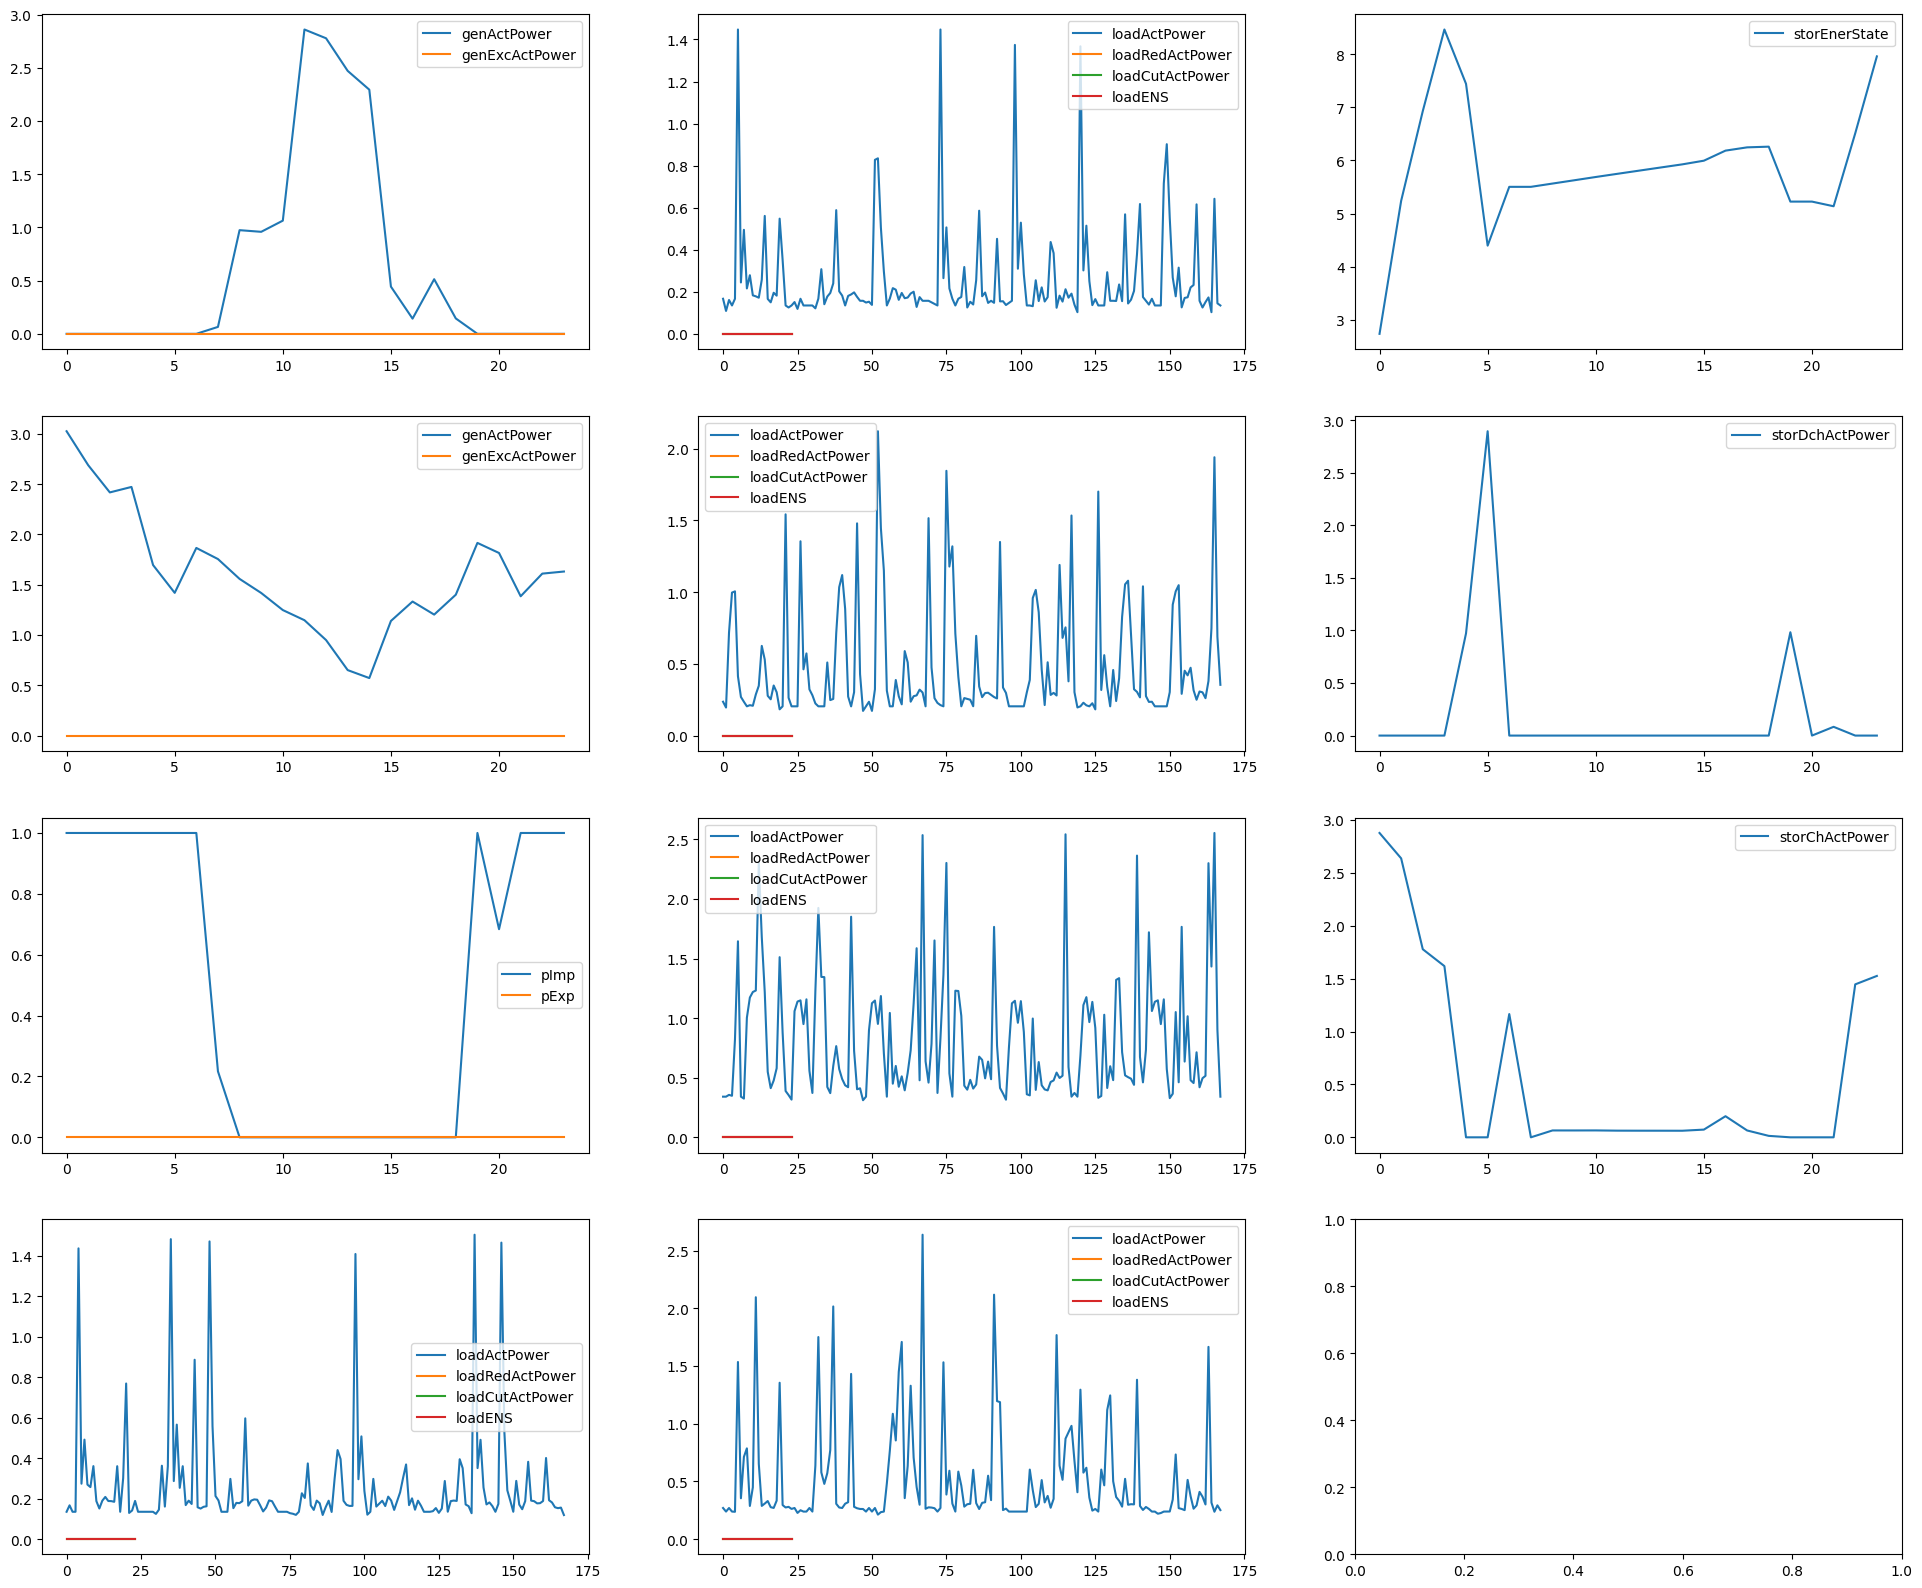

In [50]:
# Plot results

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(24, 20))

for i in np.arange(num_generators):
    # Generators
    axs[i, 0].plot(result_genActPower.values[i][:24])
    axs[i, 0].plot(result_genExcActPower.values[i][:24])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])
    
for i in np.arange(5):
    # Loads
    if (i == 0):
        x = num_generators+1
        y = 0
    else:
        x = i-1
        y = 1
    axs[x, y].plot(loadLimit[:, :, 0][i, :])
    axs[x, y].plot(result_loadRedActPower.values[i][:24])
    axs[x, y].plot(result_loadCutActPower.values[i][:24])
    axs[x, y].plot(result_loadENS.values[i][:24])
    axs[x, y].legend(['loadActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS'])


#axs[0, 2].plot(result_pimp.values)
#axs[0, 2].plot(result_pexp.values)
#axs[0, 2].legend(['pImp', 'pExp'])
axs[2, 0].plot(result_pimp.values[:24])
axs[2, 0].plot(result_pexp.values[:24])
axs[2, 0].legend(['pImp', 'pExp'])


#for i in range(1):
    #axs[i, 3].plot(result_storEnerState.values[i])
    #axs[i, 3].legend(['storEnerState'])
axs[0, 2].plot(result_storEnerState.values[0][:24])
axs[0, 2].legend(['storEnerState'])
    
#for i in range(1):
    #axs[i, 4].plot(result_storDchActPower.values[i])
    #axs[i, 4].legend(['storDchActPower'])
axs[1, 2].plot(result_storDchActPower.values[0][:24])
axs[1, 2].legend(['storDchActPower'])
    
#for i in range(1):
    #axs[i, 5].plot(result_storChActPower.values[i])
    #axs[i, 5].legend(['storChActPower'])
axs[2, 2].plot(result_storChActPower.values[0][:24])
axs[2, 2].legend(['storChActPower'])


plt.show()

### Calculate total cost

In [51]:
print('Total import cost: {}'.format(sum(result_pimp.values.ravel() * buyPrice)))

Total import cost: 6.418770876829748


In [52]:
# Used from PV
df = pd.read_csv('../results/cplex_pyomo/genActPower.csv', sep=',')
epv = df.mean(axis = 1).sum()*24
print(epv)

50.83097832599837


In [53]:
# Used from grid (imported)
df = pd.read_csv('../results/cplex_pyomo/pimp.csv', sep=',')
eg = df.mean(axis = 0).sum()*24
print(eg)

12.510638206427245


In [54]:
# Not used from PV (exported)
df = pd.read_csv('../results/cplex_pyomo/pexp.csv', sep=',')
ewpv = df.mean(axis = 0).sum()*24
print(ewpv)

2.6173934275733868


In [55]:
# Total Production
print(pv_df.mean(axis = 0)['Production']/1000*24)

84.55465784905378


C:\Users\Nuno.Velosa.CORP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


In [56]:
# Not used from PV
print(abs(pv_df.loc[pv_df.Netload <= 0, 'Netload'].mean()) / 1000*24)

98.20864061197973


In [57]:
# Used from PV
print((abs(pv_df.loc[pv_df.Netload <= 0, 'Demand'].mean()/2) + abs(pv_df.loc[pv_df.Netload > 0, 'Production'].mean()/2)) / 1000*24)

36.97796179137127


In [58]:
# Used from grid
print(pv_df.loc[pv_df.Netload > 0, 'Netload'].mean() / 1000*24)

38.109476556353314


### Create Area Chart graphs

In [59]:
!pip install seaborn

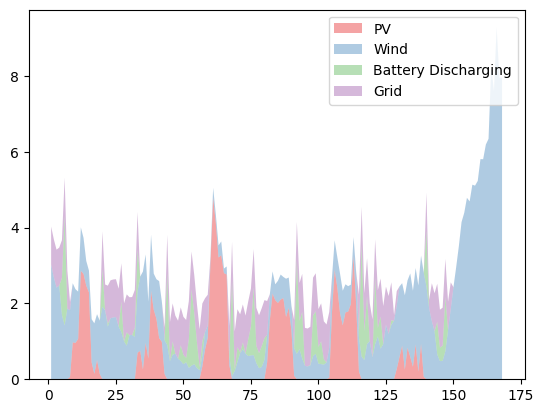

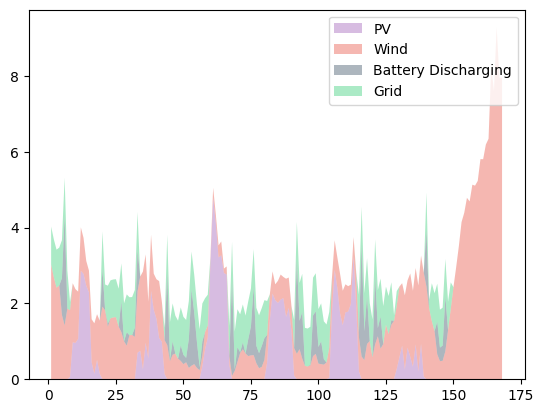

In [60]:
import seaborn as sns

act_power = pd.read_csv('../results/cplex_pyomo/genActPower.csv', sep=',')
stor_dch_power = pd.read_csv('../results/cplex_pyomo/storDchActPower.csv', sep=',')
pimp = pd.read_csv('../results/cplex_pyomo/pimp.csv', sep=',')

# Your x and y axis
x = range(1,24*7+1)
y = [ act_power.loc[0], act_power.loc[1], stor_dch_power.iloc[0], pimp["0"] ]
 
# use a known color palette
pal = sns.color_palette("Set1")
plt.stackplot(x,y, labels=['PV','Wind','Battery Discharging', 'Grid'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()
 
# create your palette
pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
plt.stackplot(x,y, labels=['PV','Wind', 'Battery Discharging', 'Grid'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()

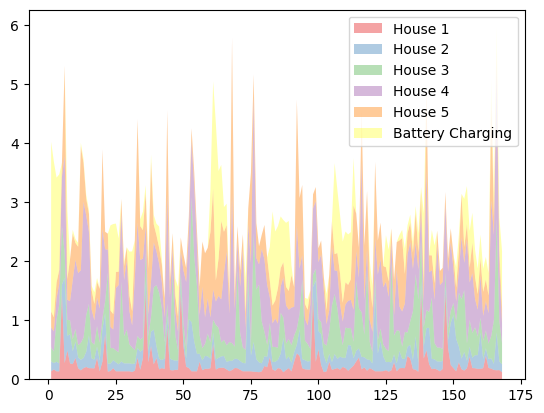

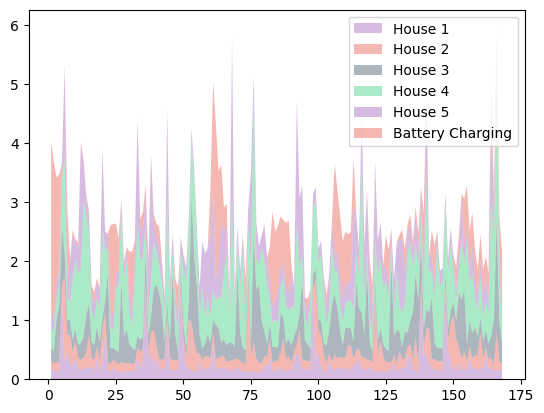

In [61]:
load_power = pd.read_csv('../results/cplex_pyomo/loadXo.csv', sep=',')
stor_ch_power = pd.read_csv('../results/cplex_pyomo/storChActPower.csv', sep=',')

#print(pimp["0"])
#print(loadLimit[:, :, 0][4, :].shape)

x = range(1,24*7+1)
y = [loadLimit[:, :, 0][0, :], loadLimit[:, :, 0][1, :], loadLimit[:, :, 0][2, :], loadLimit[:, :, 0][3, :], loadLimit[:, :, 0][4, :], stor_ch_power.iloc[0]]
 
# use a known color palette
pal = sns.color_palette("Set1")
plt.stackplot(x,y, labels=['House 1','House 2','House 3', 'House 4', 'House 5', 'Battery Charging'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()
 
# create your palette
pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
plt.stackplot(x,y, labels=['House 1','House 2','House 3', 'House 4', 'House 5', 'Battery Charging'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()

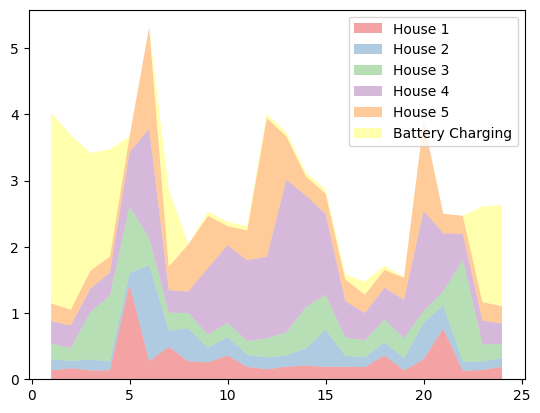

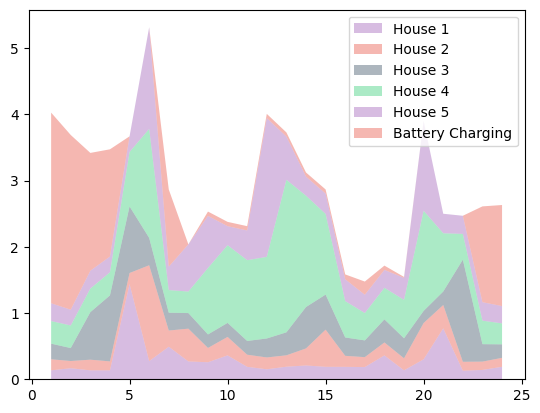

In [62]:
x = range(1,24+1)
y = [loadLimit[:, :, 0][0, :][:24], loadLimit[:, :, 0][1, :][:24], loadLimit[:, :, 0][2, :][:24], loadLimit[:, :, 0][3, :][:24], loadLimit[:, :, 0][4, :][:24], stor_ch_power.iloc[0][:24]]
 
# use a known color palette
pal = sns.color_palette("Set1")
plt.stackplot(x,y, labels=['House 1','House 2','House 3', 'House 4', 'House 5', 'Battery Charging'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()
 
# create your palette
pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
plt.stackplot(x,y, labels=['House 1','House 2','House 3', 'House 4', 'House 5', 'Battery Charging'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()

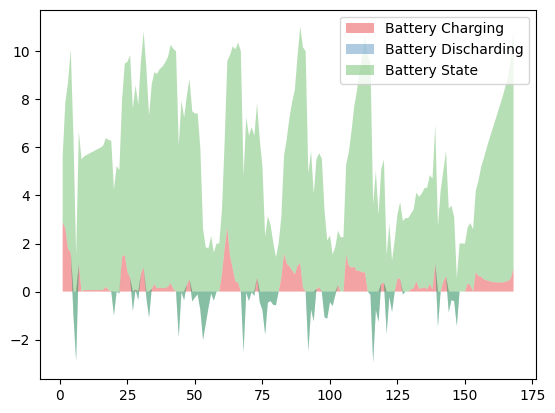

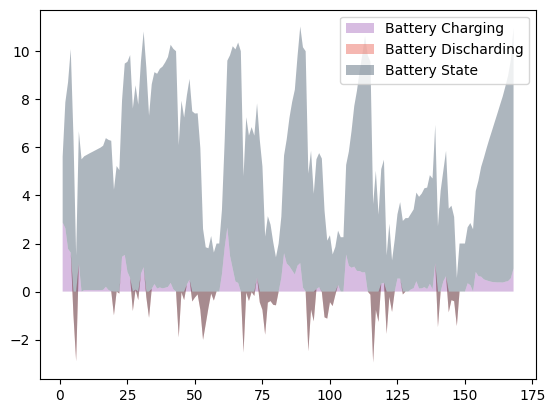

In [63]:
stor_ener_state = pd.read_csv('../results/cplex_pyomo/storEnerState.csv', sep=',')

stor_dch_power[:] = stor_dch_power[:]*(-1)

x = range(1,24*7+1)
y = [stor_ch_power.iloc[0], stor_dch_power.iloc[0], stor_ener_state.iloc[0]]
 
# use a known color palette
pal = sns.color_palette("Set1")
plt.stackplot(x,y, labels=['Battery Charging', 'Battery Discharding', 'Battery State'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()
 
# create your palette
pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
plt.stackplot(x,y, labels=['Battery Charging', 'Battery Discharding', 'Battery State'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()

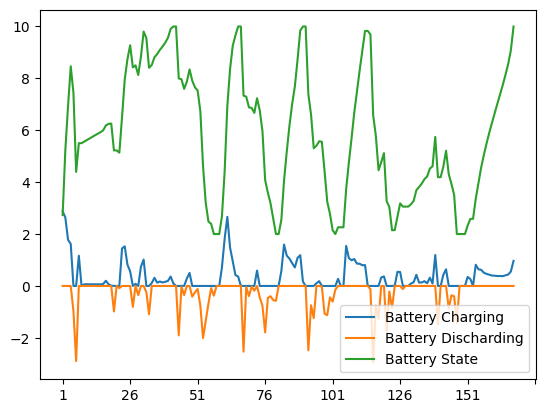

In [64]:
stor_ch_power.iloc[0].plot(legend=True, label='Battery Charging')
stor_dch_power.iloc[0].plot(legend=True, label='Battery Discharding')
stor_ener_state.iloc[0].plot(legend=True, label='Battery State')
plt.show()

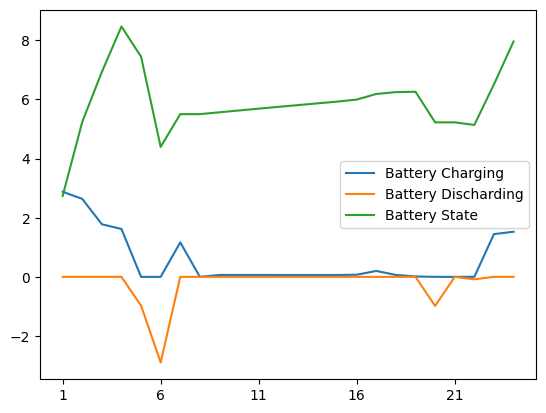

In [65]:
stor_ch_power.iloc[0][:24].plot(legend=True, label='Battery Charging')
stor_dch_power.iloc[0][:24].plot(legend=True, label='Battery Discharding')
stor_ener_state.iloc[0][:24].plot(legend=True, label='Battery State')
plt.show()

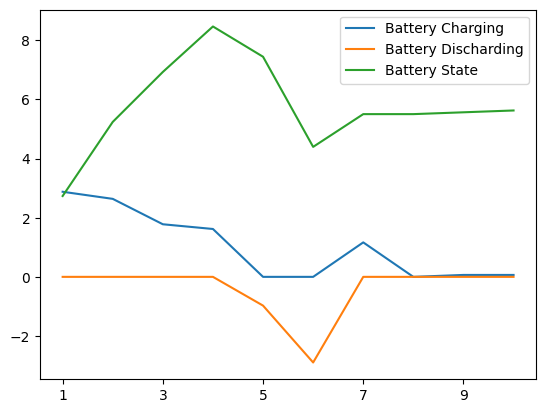

In [66]:
stor_ch_power.iloc[0][:24]

stor_ch_power.iloc[0][:10].plot(legend=True, label='Battery Charging')
stor_dch_power.iloc[0][:10].plot(legend=True, label='Battery Discharding')
stor_ener_state.iloc[0][:10].plot(legend=True, label='Battery State')
plt.show()

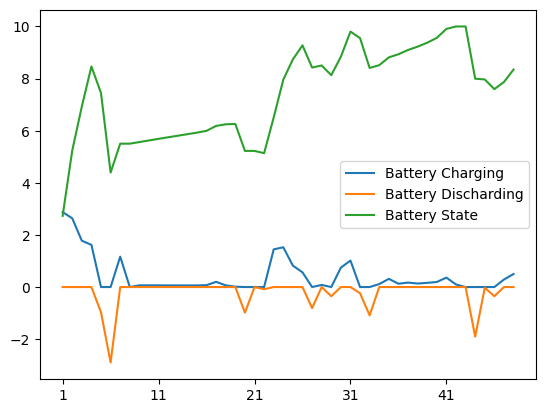

In [67]:
stor_ch_power.iloc[0][0:48].plot(legend=True, label='Battery Charging')
stor_dch_power.iloc[0][0:48].plot(legend=True, label='Battery Discharding')
stor_ener_state.iloc[0][0:48].plot(legend=True, label='Battery State')
plt.show()

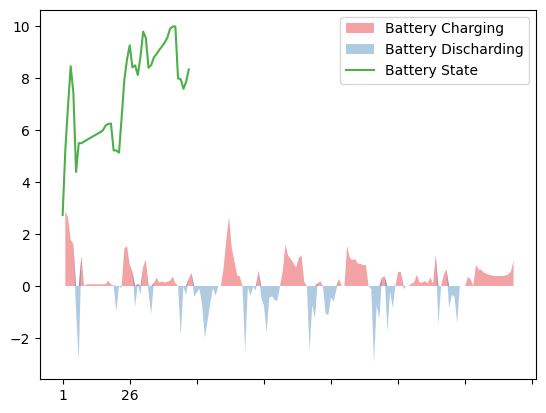

In [68]:
x = range(1,24*7+1)
y = [stor_ch_power.iloc[0], stor_dch_power.iloc[0]]
 
# use a known color palette
pal = sns.color_palette("Set1")
plt.stackplot(x,y, labels=['Battery Charging', 'Battery Discharding'], colors=pal, alpha=0.4 )
stor_ener_state.iloc[0][0:48].plot(legend=True, label='Battery State')
plt.legend(loc='upper right')
plt.show()

### Create matlab file with the model info

In [69]:
spio.savemat("matlab_matrix.mat", data)

In [70]:
data2 = spio.loadmat("matlab_matrix.mat")

In [71]:
data2

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Sun Oct 30 10:51:06 2022',
 '__version__': '1.0',
 '__globals__': [],
 'data': array([[(array([[(array([[(array([[168]]), array([[60]]), array([[2]]), array([[0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0],
                                [0, 1, 1, 1, 1, 1, 1],
                                [1, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0,